In [87]:
import warnings
warnings.simplefilter("always")

In [88]:
import matplotlib.pyplot as plt
import librosa.display

In [89]:
# This file is a part of https://github.com/pawansharmaaaa/Lip_Wise/ repository.

import os
import cv2
import torch
import subprocess
import platform

import numpy as np
import gradio as gr

from concurrent.futures import ThreadPoolExecutor

# Custom Modules
from helpers import audio
from helpers import file_check
from helpers import preprocess_mp as pmp
from helpers import model_loaders
from helpers import batch_processors

# Global Variables
TEMP_DIRECTORY = file_check.TEMP_DIR
MEDIA_DIRECTORY = file_check.MEDIA_DIR
NPY_FILES_DIRECTORY = file_check.NPY_FILES_DIR
OUTPUT_DIRECTORY = file_check.OUTPUT_DIR

In [90]:
video_path = r"E:\Lip_Wise_GFPGAN\_testData\Inputs\testing_aud.mp4"
audio_path = r"E:\Lip_Wise_GFPGAN\_testData\Inputs\testing_aud.mp3"
pad = 0
align_3d = False
face_restorer = 'CodeFormer'
fps=30
mel_step_size=16
weight = 1.0
upscale_bg = False
bgupscaler='RealESRGAN_x4plus'
gan=False
loop=False

In [91]:
# Perform checks to ensure that all required files are present
file_check.perform_check(bg_model_name=bgupscaler, restorer=face_restorer, use_gan_version=gan)

## VIDEO INFERENCE

In [92]:
# Get input type
input_type, vid_ext = file_check.get_file_type(video_path)
if input_type != "video":
    raise Exception("Input file is not a video. Try again with an video file.")

In [93]:
# Get audio type
audio_type, aud_ext = file_check.get_file_type(audio_path)
if audio_type != "audio":
    raise Exception("Input file is not an audio.")
if aud_ext != "wav":
    print("Audio file is not a wav file. Converting to wav...")
    # Convert audio to wav
    command = 'ffmpeg -y -i {} -strict -2 {}'.format(audio_path, os.path.join(MEDIA_DIRECTORY, 'aud_input.wav'))
    subprocess.call(command, shell=True)
    audio_path = os.path.join(MEDIA_DIRECTORY, 'aud_input.wav')

Audio file is not a wav file. Converting to wav...


In [94]:
# Check for cuda
free_memory = torch.cuda.mem_get_info()[0]
print(f"Initial Free Memory: {free_memory/1024**3:.2f} GB")

# Limiting the number of threads to avoid vram issues
limit = free_memory // 2e9
print(f'Limiting number of threads to {limit} to avoid vram issues.')

# Do not use GPU if free memory is less than 2GB
device = 'cuda' if torch.cuda.is_available() and limit!=0 else 'cpu'
print(f'Using {device} for inference.')

Initial Free Memory: 2.12 GB
Limiting number of threads to 1.0 to avoid vram issues.
Using cuda for inference.


In [95]:
# Create media_preprocess object and helper object
processor = pmp.ModelProcessor(padding=pad)

In [96]:
if loop:
    print("Looping video...")
    video_path = processor.loop_video(video_path=video_path, audio_path=audio_path)
else:
    pass

In [97]:
# Get face landmarks
gr.Info("Getting face landmarks...")
processor.detect_for_video(video_path)

Getting face landmarks...


In [98]:
# Load video
video = cv2.VideoCapture(video_path)

# Get video properties
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [99]:
# Generate audio spectrogram
print("Generating audio spectrogram...")
wav = audio.load_wav(audio_path, 16000)
mel = audio.melspectrogram(wav)

mel_chunks = []
#The mel_idx_multiplier aligns audio chunks with video frames for consistent processing and analysis.
mel_idx_multiplier = 80./fps
i = 0
while 1:
    start_idx = int(i * mel_idx_multiplier)
    if start_idx + mel_step_size > len(mel[0]):
        mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
        break
    mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
    i += 1

print(f"Length of mel chunks: {len(mel_chunks)}")

Generating audio spectrogram...
Length of mel chunks: 895


In [100]:
if len(mel_chunks) > frame_count:
    print("Audio is longer than video. Truncating audio...")
    mel_chunks = mel_chunks[:frame_count]
elif len(mel_chunks) < frame_count:
    print("Video is longer than audio. Truncating video...")
    frame_count = len(mel_chunks)

Video is longer than audio. Truncating video...


In [101]:
import random
indices = random.sample(range(len(mel_chunks)), 16)
indices.sort()

e:\Lip_Wise\.lip-wise\lib\site-packages\librosa\display.py:606: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return get_cmap(cmap_seq)
e:\Lip_Wise\.lip-wise\lib\site-packages\librosa\display.py:606: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return get_cmap(cmap_seq)
e:\Lip_Wise\.lip-wise\lib\site-packages\librosa\display.py:606: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return get_cmap(cmap_seq)
e:\Lip_Wise\.lip-wise\lib\site-packages\librosa\display.py:606: Matplotli

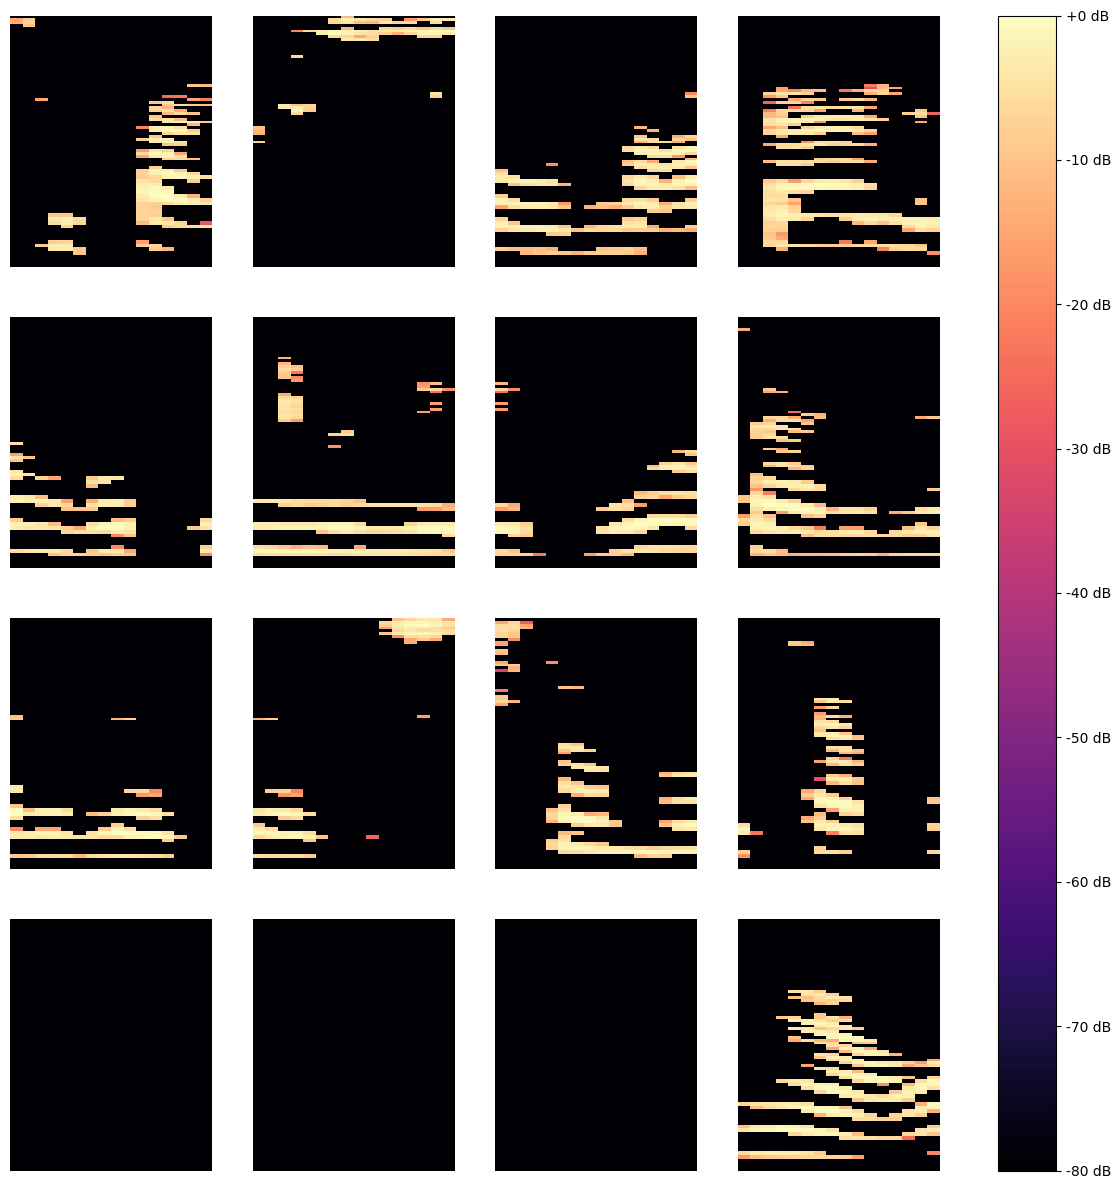

In [102]:
# Assuming `mels` is your list of mel-spectrograms
mels = [mel_chunks[i] for i in indices]

fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, ax in enumerate(axs.flatten()):
    # Get the mel-spectrogram from the list
    S = mels[i]

    # Convert to log scale (dB)
    D = librosa.power_to_db(S, ref=np.max)

    # Plot the mel-spectrogram
    img = librosa.display.specshow(D, x_axis='time', y_axis='mel', ax=ax)

    # Remove the axis labels for clarity
    ax.axis('off')

# Add a colorbar to the figure
fig.colorbar(img, ax=axs, format="%+2.f dB")

plt.show()

In [103]:
# Creating Boolean mask
total_frames = np.arange(0, frame_count) 
no_face_index = np.load(os.path.join(NPY_FILES_DIRECTORY, 'no_face_index.npy'))

mask = np.isin(total_frames, no_face_index, invert=True).astype(bool)
mask_batch = np.array_split(mask, len(mask)//16, axis=0)

In [104]:
# Split mel chunks into batches
mel_chunks = np.array(mel_chunks)
mel_chunks_batch = np.array_split(mel_chunks, len(mel_chunks)//16, axis=0)

In [105]:
# Create an array of frame numbers and split it into batches
frame_numbers = np.arange(0, frame_count)
frame_nos_batch = np.array_split(frame_numbers, frame_count//16, axis=0)

In [106]:
# Create batch helper object
bp = batch_processors.BatchProcessors()

In [107]:
# Create model loader object
ml = model_loaders.ModelLoader(face_restorer, weight)

# Load wav2lip model
w2l_model = ml.load_wav2lip_model(gan=gan)

Load CodeFormer checkpoint from: e:\Lip_Wise\weights\codeformers\codeformer.pth
Loading wav2lip checkpoint from: e:\Lip_Wise\weights\wav2lip\wav2lip.pth


## Collect Frames and rest

In [108]:
# Feed to model:
images_list = []
mels_list = []
extracted_faces_list = []
face_masks_list = []
inv_masks_list = []
cropped_faces_list = []
frame_batch_list = []
mel_batch_list = []
dubbed_faces_list = []
restored_faces_list = []
resized_restored_faces_list = []
pasted_ready_faces_list = []
ready_to_paste_list = []
restored_images_list = []
upscaled_bg_list = []

In [ ]:
batch_no = 0
images = []
while (batch_no < 16):
    ret, frame = video.read()

    if not ret:
        break

    frame_no = int(video.get(cv2.CAP_PROP_POS_FRAMES))
    images.append(frame)

    if len(images) == len(mask_batch[batch_no]):
        
        frames = np.array(images)
        frame_nos_to_input = frame_nos_batch[batch_no][mask_batch[batch_no]]
        mels_to_input = mel_chunks_batch[batch_no][mask_batch[batch_no]]
        frames_to_input = frames[mask_batch[batch_no]]
        
        if len(frames_to_input) != 0 and len(mels_to_input) != 0:
            extracted_faces, face_masks, inv_masks, centers, bboxes = bp.extract_face_batch(frames_to_input, frame_nos_to_input)

            # Save Data
            extracted_faces_list.append(extracted_faces[0])
            face_masks_list.append(face_masks[0])
            inv_masks_list.append(inv_masks[0])


            cropped_faces, aligned_bboxes, rotation_matrices = bp.align_crop_batch(extracted_faces, frame_nos_to_input)
            
            # Save Data
            cropped_faces_list.append(cropped_faces[0])


            frame_batch, mel_batch = bp.gen_data_video_mode(cropped_faces, mels_to_input)
            # Save Data
            frame_batch_list.append(frame_batch[0])
            mel_batch_list.append(mel_batch[0])


            # Feed to wav2lip model:
            frame_batch = torch.FloatTensor(np.transpose(frame_batch, (0, 3, 1, 2))).to(device)
            mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)

            with torch.no_grad():
                dubbed_faces = w2l_model(mel_batch, frame_batch)
            
            dubbed_faces = dubbed_faces.cpu().numpy().transpose(0, 2, 3, 1) * 255.
            # Save Data
            dubbed_faces_list.append(dubbed_faces[0])

            if face_restorer == 'CodeFormer':
                with ThreadPoolExecutor(max_workers=limit) as executor:
                    restored_faces = list(executor.map(ml.restore_wCodeFormer, dubbed_faces))
            elif face_restorer == 'GFPGAN':
                with ThreadPoolExecutor(max_workers=limit) as executor:
                    restored_faces = list(executor.map(ml.restore_wGFPGAN, dubbed_faces))
            elif face_restorer == 'RestoreFormer':
                with ThreadPoolExecutor(max_workers=limit) as executor:
                    restored_faces = list(executor.map(ml.restore_wRF, dubbed_faces))
            elif face_restorer == "None":
                restored_faces = dubbed_faces
            else:
                raise Exception("Invalid face restorer model. Please check the model name and try again.")
            
            # Save Data
            restored_faces_list.append(restored_faces[0])
            
            # Post processing
            resized_restored_faces = bp.face_resize_batch(restored_faces, cropped_faces)
            resized_restored_faces_list.append(resized_restored_faces[0])
            pasted_ready_faces = bp.paste_back_black_bg_batch(resized_restored_faces, aligned_bboxes, frames_to_input, ml)
            pasted_ready_faces_list.append(pasted_ready_faces[0])
            ready_to_paste = bp.unwarp_align_batch(pasted_ready_faces, rotation_matrices)
            ready_to_paste_list.append(ready_to_paste[0])
            restored_images = bp.paste_back_batch(ready_to_paste, frames_to_input, face_masks, inv_masks, centers)
            restored_images_list.append(restored_images[0])

            if upscale_bg:
                frame, _ = ml.restore_background(restored_images[0], bgupscaler, tile=400, outscale=1.0, half=False)
                upscaled_bg_list.append(frame)
        
        print(f"Writing batch no: {batch_no+1} out of total 16 batches.")
        batch_no += 1

        images = []

video.release()

In [ ]:
# Assuming `images` and `mels` are your lists of images and mel-spectrograms as numpy arrays
images_rand = 
mels_rand = 

fig, axs = plt.subplots(len(images_rand), 3, figsize=(15, 50))

for i, ax in enumerate(axs):
    # Split the concatenated image into two separate images
    img1 = images_rand[i][:, :, :3]
    img2 = images_rand[i][:, :, 3:]

    # Plot the images and mel-spectrogram
    ax[0].imshow(img1[:,:,::-1])
    ax[1].imshow(img2[:,:,::-1])

    # Convert to log scale (dB). If the mel-spectrogram is already in dB, you can skip this.
    D = librosa.power_to_db(mels_rand[i], ref=np.max)
    # Squeeze the last dimension of D
    D = np.squeeze(D)
    # Plot the mel-spectrogram
    img = librosa.display.specshow(D, x_axis='time', y_axis='mel', ax=ax[2])

    # Remove the axis labels for clarity
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

    # Add labels
    if i == 0:
        ax[0].set_title('Image')
        ax[1].set_title('Masked')
        ax[2].set_title('Mel Spectrogram')

plt.tight_layout()
plt.show()

In [ ]:
command = f"ffmpeg -y -i {audio_path} -i {os.path.join(MEDIA_DIRECTORY, 'temp.mp4')} -strict -2 -q:v 1 {os.path.join(OUTPUT_DIRECTORY, file_name)}"
subprocess.call(command, shell=platform.system() != 'Windows')